In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus


#Processing and Loading
items = pd.read_csv('consumer_data\\item_list.csv', sep = ';')
orders = pd.read_csv('consumer_data\\order_list.csv', sep = ';')
players = pd.read_csv('consumer_data\\players_list.csv', sep = ';')

**Data Prep**

After some initial inspection, before answering any questions, I noticed that 
there was a player who supposedly ordered 99,999 of an item, almost 2 Million Euros.
This anomoly was removed, and sets were checked for duplicates. There were no duplicates in players or items.
I did not drop duplicates for orders however, as, due to us not having the time in our day_id, we cannot be certain that a user didn't simply order the same item multiple times in a day.
In Items, Orders, Players, there are also no NA fields so I do not need to fill in any blank data.

In [2]:
#converting dates to correct format
orders['day_id'] = pd.to_datetime(orders['day_id'], format="%d/%m/%Y")
players['first_battle_dt'] = pd.to_datetime(players['first_battle_dt'], format="%d/%m/%Y")
#Remove anomaly player
orders = orders.query('item_cnt<99999')
total_player = players['user_id'].max()-1 #due to anomaly player being in here as well

# Descriptive Part
I plot the following chart: x-axis = day_id; y-axis = revenues; y-axis (dual axis) = paying users

I can join items to orders to give item price (Euros) and this also gives day_id

In [3]:
#joining orders and items on item_id. Only adding item_id, item_price and item_name
#This will be our main set when dealing with orders now.
orders_with_items = pd.merge(orders, items[['item_id','item_price', 'item_name']], how = 'left', on='item_id')
#creating a new field called net_amount that calculates the net amount of revenue generated by that line.
orders_with_items = orders_with_items.assign(net_amount=lambda x: x.item_price * x.item_cnt)
#group on day_id, and aggregate by user and sum the amount.
days_players = orders_with_items.groupby('day_id', as_index=False).agg({"user_id": lambda x: x.nunique(), "net_amount": np.sum})


In [4]:
#Graph making
days = days_players['day_id'].values
revenue = days_players['net_amount'].values
users = days_players['user_id'].values

fig = go.Figure(
    data = go.Scatter(
        x = days,
        y = revenue,
        name = "Total Revenue"
    ),
)

fig.add_trace(
    go.Scatter(
        x = days,
        y = users,
        yaxis = "y2", 
        name = "Unique paying users"
    ),
)

fig.update_layout(
    legend = dict(orientation="h"),
    yaxis = dict(
        title = dict(text="Total Revenue"),
        side = "left",
        range =[5500,13500]),
    yaxis2 = dict(
        title = dict(text="Unique paying users"),
        side = "right",
        range = [250,450],
        overlaying = "y",
        tickmode = "auto",
    ),
)

fig.show()
    

The graph shows, the Total Revenue and Unqiue paying users track almost identically to each other. If we look at the drop in revenue we see a drop of around 7.3K(Euros) due to a drop of 122 unique paying users. At the start of the graph, the average spend per user is around 30(Euros), after the drop it is around 19(Euros). The average revenue for the users lost in the drop was around 60(Euros) per user. This implies that the paying users we lost on the 10th of Jan were paying significantly above the rest of our paying users.

The drop off of paying users in early January is likely due to season affect or a seasonal promotion coming to an end.

## What is the total revenue for the period
247652 Euros

In [5]:
total_revenue = sum(revenue)
total_revenue

247652

## How many paying players do we have?
5920 users

In [6]:
paying_users = orders_with_items['user_id'].nunique()
paying_users

5920

## What is the percentage of paying players among all players (conversion rate)?
20000 user_id's in players_list.csv

unique paying_users = 5920
total_players = 19999

Conversion rate = 0.296 or 29.6%

In [7]:
conversion_rate = paying_users/total_player
conversion_rate

0.296014800740037

## What is the top item in terms of revenues?
itemE with 59500 Euros

In [8]:
#the safer way to do it is with ids due to strings sometimes being different, however as this data is clean
#We can group by item_name. This also makes it more readable without the need for messy code or a join
orders_with_items.groupby('item_id', as_index=False).agg({"net_amount": np.sum}).sort_values('net_amount', ascending = False).reset_index(drop = True)
orders_with_items.groupby('item_name', as_index=False).agg({"net_amount": np.sum}).sort_values('net_amount', ascending = False).reset_index(drop = True)

item_name  net_amount
0     itemE       59500
1     itemD       47150
2     Pack3       29040
3     itemC       28550
4     itemB       25340
5     Pack1       24400
6     Pack2       16860
7     Pack4       12122
8     itemA        4690

## What is the top item in terms of units sold?
Pack1 - 2440

In [9]:
orders_with_items.groupby('item_name', as_index=False).agg({"item_cnt": np.sum}).sort_values('item_cnt', ascending = False).reset_index(drop = True)

item_name  item_cnt
0     Pack1      2440
1     itemD      1886
2     itemB      1267
3     itemE      1190
4     itemC      1142
5     Pack4      1102
6     Pack3       968
7     Pack2       843
8     itemA       469

## At which day of the week (1=Monday, ...7 = Sunday) is the average transaction (in EUR) the highest?

Saturday(6) has the highest average(Euro) transactions, averaging 24.4 Euros per transaction

In [10]:
#Adding day of the week as a field
orders_with_days = orders_with_items.assign(day_of_week = lambda x: x.day_id.dt.dayofweek+1)
#Graphing as Histogram to easily get avg
fig = px.histogram(orders_with_days, x='day_of_week', y='net_amount',histfunc='avg',nbins=7, text_auto=True)                                                                          
fig.update_layout(bargap=0.2)
fig.show()

## What is the average amount of items bought for paying users?

We know the total number of unique payuing users is 5920, so we need the total number of items bought

Mean = 1.9, median = 2.0

In [11]:
total_items_by_user = orders_with_items.groupby('user_id', as_index=False).agg({"item_cnt": np.sum}).sort_values('item_cnt', ascending = False).reset_index(drop = True)
mean = total_items_by_user['item_cnt'].mean()
median = total_items_by_user['item_cnt'].median()
print("mean: {:.1f}, median:  {:.1f}".format(mean,median))

mean: 1.9, median:  2.0


## Creating a summary table

In [12]:
orders_with_items
table_9 = orders_with_items.groupby('item_name').agg({"user_id": lambda x: x.nunique(),"net_amount": np.sum})
table_9 = table_9.assign(conversion_rate = lambda x: x.user_id/total_player)
table_9.rename(columns={"user_id":"Paying players", "net_amount":"Revenues", "conversion_rate": "Converstion rate"})

Paying players  Revenues  Converstion rate
item_name                                            
Pack1                2045     24400          0.102255
Pack2                 741     16860          0.037052
Pack3                 898     29040          0.044902
Pack4                 976     12122          0.048802
itemA                 449      4690          0.022451
itemB                1107     25340          0.055353
itemC                1035     28550          0.051753
itemD                1655     47150          0.082754
itemE                1077     59500          0.053853

---

## Data construction

Adding the following new columns to the players_list.csv file:

**is_payer**: Boolean; 1 if the player bought an item, 0 if not.

**first_itemE_date**: Date; date at which the player bought for the first time item E. If the player never bought it =
01/01/1900.


In [13]:
#Adding is_payer by seeing if the user_id occurs in the orders set
players['is_payer'] = players['user_id'].isin(orders['user_id']
                                   ).astype(int)
#Create a function that adds a column with each items first purchase date by customer
def add_item_col(set1, set2, item):
    out_set = pd.merge(set1, set2.query(f"item_name == '{item}'")
             .groupby('user_id', as_index=False)
             .agg({'day_id':min})
             [['day_id','user_id']]
             , 'left', on='user_id').rename(columns={'day_id':f'first_{item}_date'}).fillna('01/01/1900')
    return out_set

#creating a function to encode whether an item was bought or not
def item_payer(set1, item):
    set1[f'{item}_payer'] = np.where(set1[f'first_{item}_date'] 
                                     != pd.Timestamp(1900,1,1),1,0)
    return set1

    
#Adding item_date columns
interim = add_item_col(players, orders_with_items, "itemA")
interim = add_item_col(interim, orders_with_items, "itemB")
interim = add_item_col(interim, orders_with_items, "itemC")
interim = add_item_col(interim, orders_with_items, "itemD")
interim = add_item_col(interim, orders_with_items, "itemE")
interim = add_item_col(interim, orders_with_items, "Pack1")
interim = add_item_col(interim, orders_with_items, "Pack2")
interim = add_item_col(interim, orders_with_items, "Pack3")
interim = add_item_col(interim, orders_with_items, "Pack4")
#Adding Encoded columns
interim = item_payer(interim, "itemA")
interim = item_payer(interim, "itemB")
interim = item_payer(interim, "itemC")
interim = item_payer(interim, "itemD")
interim = item_payer(interim, "itemE")
interim = item_payer(interim, "Pack1")
interim = item_payer(interim, "Pack2")
interim = item_payer(interim, "Pack3")
players_first_item_dt = item_payer(interim, "Pack4")

#Adding day of the week columns for first purcahse dates
players_first_item_dt = players_first_item_dt.assign(day_of_week_iA = lambda x: x.first_itemA_date.dt.dayofweek+1)
players_first_item_dt = players_first_item_dt.assign(day_of_week_iB = lambda x: x.first_itemB_date.dt.dayofweek+1)
players_first_item_dt = players_first_item_dt.assign(day_of_week_iC = lambda x: x.first_itemC_date.dt.dayofweek+1)
players_first_item_dt = players_first_item_dt.assign(day_of_week_iD = lambda x: x.first_itemD_date.dt.dayofweek+1)
players_first_item_dt = players_first_item_dt.assign(day_of_week_iE = lambda x: x.first_itemE_date.dt.dayofweek+1)
players_first_item_dt = players_first_item_dt.assign(day_of_week_P1 = lambda x: x.first_Pack1_date.dt.dayofweek+1)
players_first_item_dt = players_first_item_dt.assign(day_of_week_P2 = lambda x: x.first_Pack2_date.dt.dayofweek+1)
players_first_item_dt = players_first_item_dt.assign(day_of_week_P3 = lambda x: x.first_Pack3_date.dt.dayofweek+1)
players_first_item_dt = players_first_item_dt.assign(day_of_week_P4 = lambda x: x.first_Pack4_date.dt.dayofweek+1)

## Data mining

I am interested in answering two questions:

a. What makes players spend money?

b. What makes players buy Pack 4?

**a.** 

Here we are trying to work out from what features we have if there is any correlation between a player that has spent money and any other feature that describes them.

I want to see if; wins, win/loss(win_rate), total battles, or playtime correlates with making any payment at all


In [14]:
#Makeing w_rate field
players_df = players_first_item_dt.assign(w_rate=lambda x: x.win_cnt/x.battles_cnt)
players_df

user_id  battles_cnt  win_cnt  total_playtime_min first_battle_dt  \
0            1         1219      646                 398      2015-06-02   
1            2         2113     1078                 382      2015-09-12   
2            3         2423     1163                 551      2015-07-11   
3            4         2199     1275                 309      2015-10-22   
4            5         2399     1343                 585      2015-07-09   
...        ...          ...      ...                 ...             ...   
19995    19996         1393      669                 424      2015-07-18   
19996    19997         1001      410                 163      2015-06-08   
19997    19998         1296      544                 246      2015-12-25   
19998    19999         1237      730                 234      2015-11-28   
19999    20000          621      298                 492      2015-08-28   

       is_payer first_itemA_date first_itemB_date first_itemC_date  \
0             1       1900-01-01       1900-01-01       2016-01-14   
1             1       2016-01-10       1900-01-01       1900-01-01   
2             0       1900-01-01       1900-01-01       1900-01-01   
3             1       1900-01-01       1900-01-01       2016-01-12   
4             1       1900-01-01       1900-01-01       1900-01-01   
...         ...              ...              ...              ...   
19995         0       1900-01-01       1900-01-01       1900-01-01   
19996         0       1900-01-01       1900-01-01       1900-01-01   
19997         0       1900-01-01       1900-01-01       1900-01-01   
19998         0       1900-01-01       1900-01-01       1900-01-01   
19999         0       1900-01-01       1900-01-01       1900-01-01   

      first_itemD_date  ... day_of_week_iA day_of_week_iB day_of_week_iC  \
0           1900-01-01  ...              1              1              4   
1           1900-01-01  ...              7              1              1   
2           1900-01-01  ...              1              1              1   
3           1900-01-01  ...              1              1              2   
4           2016-01-26  ...              1              1              1   
...                ...  ...            ...            ...            ...   
19995       1900-01-01  ...              1              1              1   
19996       1900-01-01  ...              1              1              1   
19997       1900-01-01  ...              1              1              1   
19998       1900-01-01  ...              1              1              1   
19999       1900-01-01  ...              1              1              1   

      day_of_week_iD day_of_week_iE  day_of_week_P1  day_of_week_P2  \
0                  1              1               1               1   
1                  1              1               1               1   
2                  1              1               1               1   
3                  1              5               1               1   
4                  2              1               1               1   
...              ...            ...             ...             ...   
19995              1              1               1               1   
19996              1              1               1               1   
19997              1              1               1               1   
19998              1              1               1               1   
19999              1              1               1               1   

       day_of_week_P3  day_of_week_P4    w_rate  
0                   1               1  0.529943  
1                   1               1  0.510175  
2                   1               1  0.479983  
3                   1               1  0.579809  
4                   1               1  0.559817  
...               ...             ...       ...  
19995               1               1  0.480258  
19996               1               1  0.409590  
19997               1               1

I want to see the distribution of all the playtime metrics (w_rate, battles_cnt, win_cnt, total_playtime_min) split by is_payer so we can see if there is any correlation.

From looking at the plots there are some small correlations. For example:

- total_playtime_min could indicate if a player will pay. The majority of the time no players will pay until they have spent at least ~280 minutes in the game. However, we cannot say a player has to pay after that amount of time as non-payers does not shrink as total_playtime_min increase.

- win_cnt and battles_cnt look very similar. This suggests that generally most players have started spending money by their 1,600th battle.  

- w_rate shows how much a player wins or loses does not affect whether or not they choose to spend money. This suggests that players who are winning more aren't necessarily spending money. This is good as it shows the game is not pay-to-win.

In [15]:
fig = make_subplots(rows=2, cols=2, start_cell="bottom-left"
                   ,subplot_titles=("w_rate","battles_cnt","win_cnt","total_playtime_min"))
fig.add_trace(go.Violin(x=players_df['is_payer'],y=players_df['w_rate']),
             row=1,col=1)
fig.add_trace(go.Violin(x=players_df['is_payer'],y=players_df['battles_cnt']),
             row=1,col=2)
fig.add_trace(go.Violin(x=players_df['is_payer'],y=players_df['win_cnt']),
             row=2,col=1)
fig.add_trace(go.Violin(x=players_df['is_payer'],y=players_df['total_playtime_min']),
             row=2,col=2)
fig.show()

The below correlation graph shows that there is a weak correlation between battle_cnt, win_cnt, and total_playtime_min with is_payer.  From the violin graphs above and the plot below we can conclude that win_cnt and battle_cnt are heavily correlated and someone with a high win_cnt has played more battles, not that they are winning due to some other factor. It doesn't matter whether a player is a  'winner', all that matters is how many games they have played. 

In [16]:
#making correlation plot
players_df_corr = players_df[['is_payer','w_rate','battles_cnt','win_cnt','total_playtime_min']]
players_df_corr = players_df_corr.corr()
fig = go.Figure()
fig.add_trace(go.Heatmap(x=players_df_corr.columns,
                        y=players_df_corr.index,
                        z=np.array(players_df_corr)))
fig.show()

After I looked at the above I started to ask what other factors could affect someone's decision to make a purchase. Looking at the other data I had available, and back at 'At which day of the week (1=Monday, ...7 = Sunday) is the average transaction (in EUR) the highest?'  I realised that time of the week is a factor.
    
Below  we can see that the average increase in spend on Friday and Saturday is 8.9%, with Friday seeing an increase of 6.35% compared to the rest of the days average, and Satuerday an 11.1% increase. This suggests that people are more willing to spend money on Friday and Saturday as they play over the weekend.

In [17]:
#Calculates the percent increase in average spend of weekend compared to weekedays
#Calculates the Mean net_amount by day_of_week
#Use the orders set created in question 7
orders_with_days_summarised = orders_with_days.groupby('day_of_week', as_index = 0).agg({'net_amount':'mean'})
#Calculating the percentage increases
#Fri-Sat Avg
fri_sat = orders_with_days_summarised.iloc[4:-1]['net_amount'].sum()/orders_with_days_summarised.iloc[4:-1]['net_amount'].count()
#Other Days avg.
other = (orders_with_days_summarised['net_amount'].sum() - orders_with_days_summarised.iloc[4:-1]['net_amount'].sum())/5
#Percentages
weekend_perc_inc = fri_sat/other
sat_perc_inc = orders_with_days_summarised.iloc[5:6]['net_amount'].sum()/other
fri_perc_inc = orders_with_days_summarised.iloc[4:5]['net_amount'].sum()/other
print(f'Fri-Sat Avg Increase:{weekend_perc_inc}, Sat Avg Increase:{sat_perc_inc}, Friday Avg Increase:{fri_perc_inc}')

Fri-Sat Avg Increase:1.088731850481279, Sat Avg Increase:1.1139578400465542, Friday Avg Increase:1.063505860916004


In addition to when people bought any item, I wanted to look at when people specifically initially spent money.

In [18]:
#Similarly to the itemX first purchase dates, I added a first purchase date for any items
players_df = pd.merge(players_df, orders_with_items.groupby('user_id', as_index=False)
         .agg({'day_id':min})
         [['day_id','user_id']]
         , 'left', on='user_id').rename(columns={'day_id':'first_purchase_date'}).fillna('01/01/1900')
players_df

user_id  battles_cnt  win_cnt  total_playtime_min first_battle_dt  \
0            1         1219      646                 398      2015-06-02   
1            2         2113     1078                 382      2015-09-12   
2            3         2423     1163                 551      2015-07-11   
3            4         2199     1275                 309      2015-10-22   
4            5         2399     1343                 585      2015-07-09   
...        ...          ...      ...                 ...             ...   
19995    19996         1393      669                 424      2015-07-18   
19996    19997         1001      410                 163      2015-06-08   
19997    19998         1296      544                 246      2015-12-25   
19998    19999         1237      730                 234      2015-11-28   
19999    20000          621      298                 492      2015-08-28   

       is_payer first_itemA_date first_itemB_date first_itemC_date  \
0             1       1900-01-01       1900-01-01       2016-01-14   
1             1       2016-01-10       1900-01-01       1900-01-01   
2             0       1900-01-01       1900-01-01       1900-01-01   
3             1       1900-01-01       1900-01-01       2016-01-12   
4             1       1900-01-01       1900-01-01       1900-01-01   
...         ...              ...              ...              ...   
19995         0       1900-01-01       1900-01-01       1900-01-01   
19996         0       1900-01-01       1900-01-01       1900-01-01   
19997         0       1900-01-01       1900-01-01       1900-01-01   
19998         0       1900-01-01       1900-01-01       1900-01-01   
19999         0       1900-01-01       1900-01-01       1900-01-01   

      first_itemD_date  ... day_of_week_iB day_of_week_iC day_of_week_iD  \
0           1900-01-01  ...              1              4              1   
1           1900-01-01  ...              1              1              1   
2           1900-01-01  ...              1              1              1   
3           1900-01-01  ...              1              2              1   
4           2016-01-26  ...              1              1              2   
...                ...  ...            ...            ...            ...   
19995       1900-01-01  ...              1              1              1   
19996       1900-01-01  ...              1              1              1   
19997       1900-01-01  ...              1              1              1   
19998       1900-01-01  ...              1              1              1   
19999       1900-01-01  ...              1              1              1   

      day_of_week_iE day_of_week_P1  day_of_week_P2  day_of_week_P3  \
0                  1              1               1               1   
1                  1              1               1               1   
2                  1              1               1               1   
3                  5              1               1               1   
4                  1              1               1               1   
...              ...            ...             ...             ...   
19995              1              1               1               1   
19996              1              1               1               1   
19997              1              1               1               1   
19998              1              1               1               1   
19999              1              1               1               1   

       day_of_week_P4    w_rate  first_purchase_date  
0                   1  0.529943           2016-01-14  
1                   1  0.510175           2016-01-10  
2                   1  0.479983           1900-01-01  
3                   1  0.579809           2016-01-01  
4                   1  0.559817           2016-01-26  
...               ...       ...                  ...  
19995               1  0.480258           1900-01-01  
19996               1  0.409590           1900-

From the below graph we can see first purchases are even more staggeringly skewed toward the weekend, with Friday having the most purchases (a 44% increase on the Mon-Thu average(733.5(Euros))), with purchases tapering down through the week.

It is worth noting how Sunday has a very high number of first purchases, even though it typically has the lowest average transaction amount.

In [19]:
#Converting date to day of the week
players_df = players_df.assign(day_of_week_FP = lambda x: x.first_purchase_date.dt.dayofweek+1)
#new set for players that have paid
players_payers = players_df.query('is_payer == 1')
fig = px.histogram(players_payers, x = 'day_of_week_FP', text_auto = True)
fig.show()

From the graphs above we can conclude that the strongest driving factors
behind why a player would spend money are:
    
   - their free-time/day of the week (if it is a Friday, Saturday, or Sunday)
    
   - how long they have spent in the game/how many battles they have played
    
However, these features do not have a strong correlatation with a player spending money, as most players have not spent money.  

b. What makes players buy Pack 4?

**b.** 
To start answering this question I explored the correlations of Pack4 with various items from the data set. 

In [20]:
#More up-to-date players who are payers set
payers = players_df.query('is_payer == 1')

As we can see from the below graphs there are some items see little variance over the week (Pack2), and then others like itemE spike massivley on Friday and Saturday. This in addition to the general spike on Friday and Saturday for all items, will contribute largely to Friday and Saturday's big spike.

In [21]:
#Making a distribution figure for all first purchase days
fig = make_subplots(rows=3, cols=3, start_cell="bottom-left"
                   ,subplot_titles=("itemA","itemB","itemC","itemD",
                                   "itemE","Pack1","Pack2","Pack3",
                                   "Pack4"))
fig.add_trace(go.Histogram(x=payers.query('itemA_payer == 1')['day_of_week_iA']),
             row=1,col=1)
fig.add_trace(go.Histogram(x=payers.query('itemB_payer == 1')['day_of_week_iB']),
             row=1,col=2)
fig.add_trace(go.Histogram(x=payers.query('itemC_payer == 1')['day_of_week_iC']),
             row=1,col=3)
fig.add_trace(go.Histogram(x=payers.query('itemD_payer == 1')['day_of_week_iD']),
             row=2,col=1)
fig.add_trace(go.Histogram(x=payers.query('itemE_payer == 1')['day_of_week_iE']),
             row=2,col=2)
fig.add_trace(go.Histogram(x=payers.query('Pack1_payer == 1')['day_of_week_P1']),
             row=2,col=3)
fig.add_trace(go.Histogram(x=payers.query('Pack2_payer == 1')['day_of_week_P2']),
             row=3,col=1)
fig.add_trace(go.Histogram(x=payers.query('Pack3_payer == 1')['day_of_week_P3']),
             row=3,col=2)
fig.add_trace(go.Histogram(x=payers.query('Pack4_payer == 1')['day_of_week_P4']),
             row=3,col=3)
fig.show()

 From the correlation graph below we can see that Pack4 is highly correlated with itemE.
Therefore the next question I had was; do people who buy Pack4 then buy itemE, or is it the other way round.

In [22]:
#Correlation Graph for Pack4
players_items_corr = players_df[['is_payer','w_rate','battles_cnt',
                                                            'win_cnt','total_playtime_min',
                                                            'itemA_payer','itemE_payer',
                                                           'itemC_payer','itemD_payer',
                                                           'itemE_payer','Pack1_payer',
                                                           'Pack2_payer','Pack3_payer',
                                                           'Pack4_payer']]
players_items_corr = players_items_corr.corr()
fig = go.Figure()
fig.add_trace(go.Heatmap(x=players_items_corr.columns,
                        y=players_items_corr.index,
                        z=np.array(players_items_corr)))
fig.show()


In [23]:
#Only taking fields I might want to plot. Only bringing rows of people who 
#bought both itemE and Pack4
Pack4_itemE_payers = players_df[['user_id', 'battles_cnt', 
                                                    'w_rate','battles_cnt',
                                                    'win_cnt','total_playtime_min', 
                                                    'itemE_payer', 'Pack4_payer',
                                                    'first_itemE_date','first_Pack4_date',
                                                  'first_battle_dt']].query('itemE_payer == 1 and Pack4_payer ==1')

#Making a function to check whether the itemE was bought before, after or on the same day as the Pack4
def date_check(set1):
    if set1['first_itemE_date'] > set1['first_Pack4_date']:
        val = 1
    elif set1['first_itemE_date'] < set1['first_Pack4_date']:
        val = -1
    else :
        val = 0
    return val

Pack4_itemE_payers['itemE_purchased_when'] = Pack4_itemE_payers.apply(date_check, axis=1)
#Calcualting how long it takes people between buying itemE and buying Pack4
Pack4_itemE_payers = Pack4_itemE_payers.assign(date_diff = lambda x: x.first_Pack4_date - x.first_itemE_date)
#Converting from timedelta to number(days)
Pack4_itemE_payers['date_diff'] = (Pack4_itemE_payers['date_diff'].astype('timedelta64[s]'))/86400
Pack4_itemE_payers.describe()

user_id  battles_cnt      w_rate  battles_cnt      win_cnt  \
count   724.000000   724.000000  724.000000   724.000000   724.000000   
mean   4056.511050  1487.562155    0.494129  1487.562155   734.964088   
std    1862.624239   591.268807    0.059773   591.268807   306.031727   
min       4.000000   508.000000    0.399254   508.000000   204.000000   
25%    2439.000000   985.250000    0.440132   985.250000   476.000000   
50%    3967.000000  1441.500000    0.490127  1441.500000   707.000000   
75%    5389.500000  2021.750000    0.540422  2021.750000   972.250000   
max    7900.000000  2497.000000    0.600377  2497.000000  1484.000000   

       total_playtime_min  itemE_payer  Pack4_payer  itemE_purchased_when  \
count          724.000000        724.0        724.0            724.000000   
mean           456.810773          1.0          1.0             -0.966851   
std             89.877118          0.0          0.0              0.238728   
min            300.000000          1.0          1.0             -1.000000   
25%            378.750000          1.0          1.0             -1.000000   
50%            459.500000          1.0          1.0             -1.000000   
75%            535.000000          1.0          1.0             -1.000000   
max            600.000000          1.0          1.0              1.000000   

        date_diff  
count  724.000000  
mean    14.542818  
std      7.625726  
min     -2.000000  
25%      8.750000  
50%     14.000000  
75%     21.000000  
max     30.000000

From looking at the mean of itemE_purchased_when we can see that the majority of itemE's were purchased before the Pack4 was
purchased. 

Since itemE is the most expensive heavy item we can assume a high correlation between purchasing of Pack4 with people who are already willing to spend a lot of money on the game
On top of this we can see that 724 of the itemE_payers also bought Pack4 this is 67% of the itemE_payers, and 74% of the Pack4_payers.
We could potentially investigate this further by looking at total overlap of 
the players who bought itemE with buying other items to see if players who buy Pack4 are mainly the players who not only buy itemE but if these players are also the players who buy the majority of the items in the shop.

Below I plot a histogram of when itemE was purchased vs when Pack4 was purchased. This helps visualise better the conclusions we have come to already.

In [24]:
#Plotting itemE purchase dates vs Pack4 purchase dates 
#for players who bought both
fig = go.Figure()
fig.add_trace(go.Histogram(x=Pack4_itemE_payers['first_Pack4_date'], name='Pack4_date'))
fig.add_trace(go.Histogram(x=Pack4_itemE_payers['first_itemE_date'], name='itemE_date'))
fig.update_layout(barmode='stack')
fig.show()

Below is a histogram of how long it takes players to buy Pack4 after they buy itemE. We can see it is fairly normally distributed, with most people taking around 10-11 days to purchase Pack4 after purchasing itemE. 

In [25]:
fig = px.histogram(Pack4_itemE_payers,x='date_diff')
fig.show()

Finally I explore the relationship between item_cnt and net_amount. I added these without the item_cnt or net_amount for Pack4 by any user who bought it.

In [26]:
#Obtaining the data I want to joing
players_item = orders_with_items.loc[orders_with_items['item_name'] != 'Pack4'].groupby(['user_id'], as_index = False).agg({'item_cnt':'sum','net_amount':'sum'})
#Adding net_amount and item_cnt
players_with_rev = pd.merge(players_df,players_item,
                           how = 'left', on='user_id')

#Filling all net_amounts and item_cnts with 0
players_with_rev = players_with_rev.fillna(0)

In [27]:
#Updated Correlation Plot
players_with_rev_corr = players_with_rev[['is_payer','total_playtime_min',
                                          'itemA_payer','itemB_payer',
                                          'itemC_payer','itemD_payer',
                                        'itemE_payer','Pack1_payer',
                                        'Pack2_payer','Pack3_payer',
                                        'Pack4_payer', 'item_cnt', 'net_amount']]
players_with_rev_corr = players_with_rev_corr.corr()
fig = go.Figure()
fig.add_trace(go.Heatmap(x=players_with_rev_corr.columns,
                        y=players_with_rev_corr.index,
                        z=np.array(players_with_rev_corr)))
fig.show()

From the above correlation plot we can see that Pack4 isn't strongly correlated with either a large amount of items bought or a large amount of money spent. It has a correlation of ~0.45 with net_amount, but this is most likely due to Pack4 being correlated with itemE, which costs 50(Euros). The idea that people who buy a lot of items and spend a lot of money buy Pack4 can not be said to be true. 

Lastly we will try to classify our data using a decision tree to see if there are any hidden patterns that we couldn't find with our exploratory data analysis.

We cannot use day of the week of purchase as for any user who purchased nothing the date is set at 01-01-1900, which is a Monday, massively skewing all the day_of_week fields. 
We also have to shrink the amount of data we have as if we don't match the number of negative(0s) Pack4_payer with the number of positives(1s), we will have around 13000 rows of negatives, which will skews the model, and mean it looks very accurate because it is very good at classifying who won't buy Pack4 rather than who will.

In [28]:
#Collating our features
feature_cols = ['battles_cnt','win_cnt',
                 'total_playtime_min',
                 #'w_rate', #not using win rate as it is hard to read in the output and understand it's significance.
                 'itemA_payer',
                 'itemB_payer',
                 'itemC_payer',
                 'itemD_payer',
                 'itemE_payer',
                 'Pack1_payer',
                 'Pack2_payer',
                 'Pack3_payer',
                 'item_cnt',
                 'net_amount']

#randomize
pre_model_df = players_with_rev.sample(frac=1)
#y.value_counts()
#976 positive, 19024 negative. Need to get our sets down before the X,y 
#split so that there is an equal amount of positive and negative
P4_df = pre_model_df.loc[pre_model_df['Pack4_payer']==1]
no_P4_df = pre_model_df.loc[pre_model_df['Pack4_payer']==0][:976]

normal_dist_df = pd.concat([P4_df,no_P4_df])

model_df = normal_dist_df.sample(frac=1, random_state=42)

In [29]:
#Splitting into features and labels
X = model_df[feature_cols]
y = model_df['Pack4_payer']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test


# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth=4)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

#Set depth to 3-5 to get a more easily understandable tree, leave it null
#to see how the model actually considers feature importance

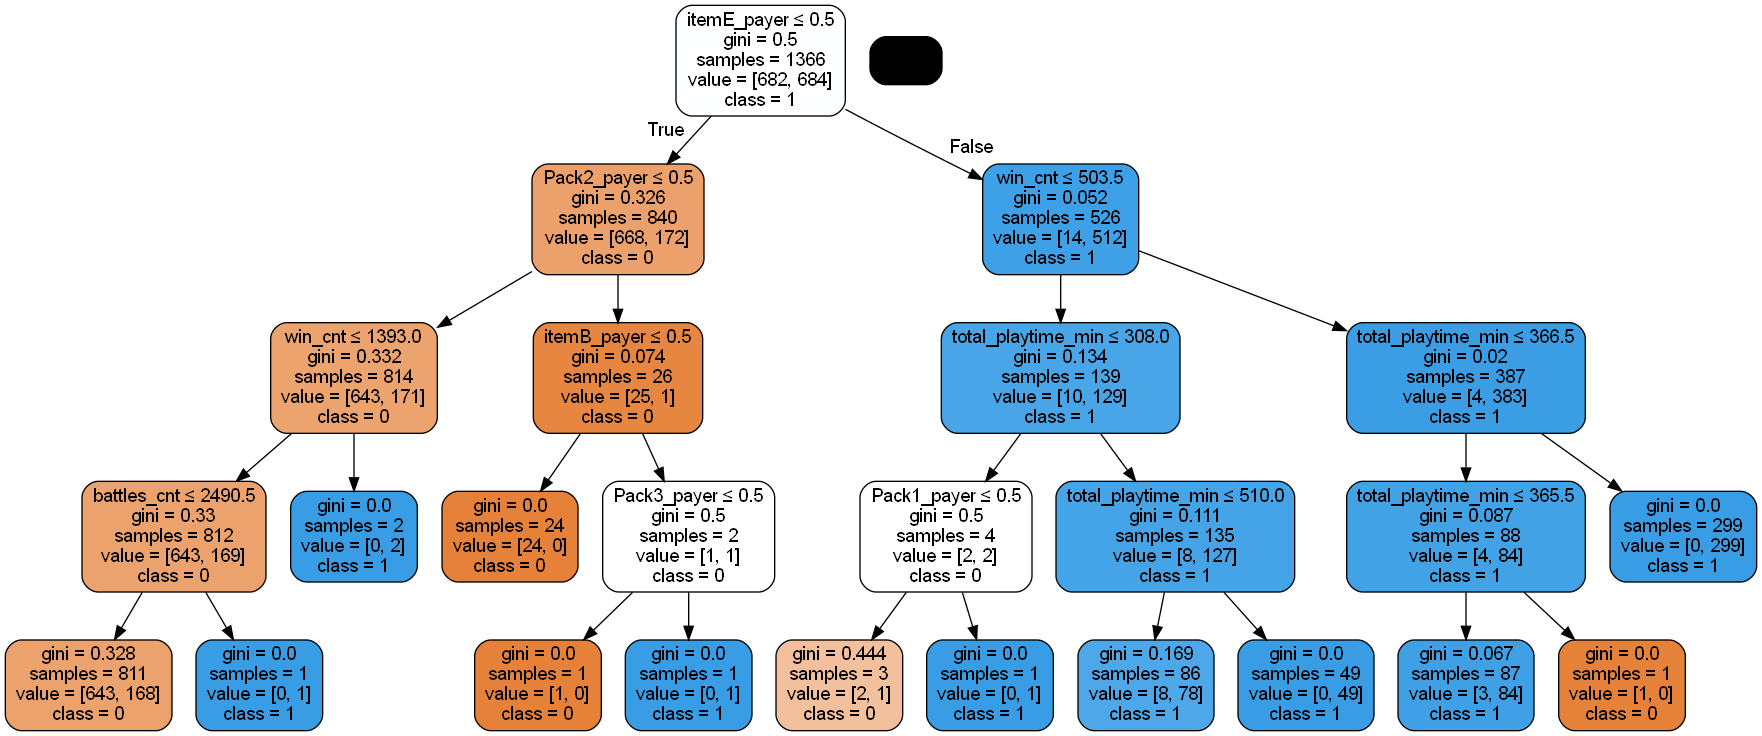

In [30]:
#Visualising the Decision Tree
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Pack4.png')
Image(graph.create_png())

In [31]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.97      0.86       294
           1       0.95      0.73      0.82       292

    accuracy                           0.85       586
   macro avg       0.87      0.85      0.84       586
weighted avg       0.87      0.85      0.84       586



In [32]:
importance = clf.feature_importances_
# summarize feature importance
cols = np.array(feature_cols)
feat_importance = pd.DataFrame({'feature':cols,'importance':list(importance)}, columns = ['feature','importance'] )
feat_importance.sort_values('importance', ascending=False)

feature  importance
7          itemE_payer    0.967639
2   total_playtime_min    0.010567
1              win_cnt    0.008300
9          Pack2_payer    0.003757
0          battles_cnt    0.003179
10         Pack3_payer    0.002532
4          itemB_payer    0.002337
8          Pack1_payer    0.001688
3          itemA_payer    0.000000
5          itemC_payer    0.000000
6          itemD_payer    0.000000
11            item_cnt    0.000000
12          net_amount    0.000000

From the accuracy metrics we can see that overall it has a decent accuracy of classifying who is a Pack4_payer. In order to understand how it does this and answer 'What makes players buy Pack 4?' we need to look at the feature importance. We see that itemE_payer is highly important in recognising whether or not the player is going to purchase Pack4. The playtime metrics are used to clasify some fringe cases but mostly the high correlation we saw earlier stands, no real hidden patterns were discovered. 
    
*Do note the model has not been tuned and could be more optimal leading to better results. I do not think that it will change the feature importance much as the accuracy of the model diminshes as we increase the depth of the tree*

To answer 'What makes a Player buy Pack4?' I think we can say firstly, similar things as to what makes a player spend money initially. A lot of battles and time in the game, and whether it is a weekend makes you more likely to purchase Pack4, but more importantly, whether you have previously purchased itemE. This seems to be far and away the biggest indicator of whether a player will purchase Pack4.
This is either due to the player being a 'whale', and therefore always going for the premium option i.e. itemE, and Pack4 > Pack1 or Pack4 gives them a good amount of currency to edit or improve their itemE in some way in the game.
